# Traffic Sign Recognition

## Dependencies

In [1]:
from numpy.random import seed
seed(86148)

import sys
sys.path.append('./lib') # For personal extra modules

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler as LRS
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

#EXTRAS
from cutout import get_random_eraser # CutOut
from mixup import MixupGenerator # Mixup

#MANAGEMENT PURPOSES ONLY
from tqdm.notebook import tqdm

Init Plugin
Init Graph Optimizer
Init Kernel


## System checks

In [2]:
print(tf.config.list_physical_devices())
tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-01-21 17:58:36.951113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-21 17:58:36.951386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

Metal device set to: Apple M1


In [3]:
from platform import python_version

print(python_version())

3.9.7


## Data management

In [4]:
data_path = r"./DATASET/"
img_size = 32

In [5]:
def load_data(dataset):
    images = []
    classes = []    
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
            
    with tqdm(total=len(rows)+1) as pbar:
    
        for i, row in rows.iterrows():
            img_class = row["ClassId"]
            img_path = row["Path"]        
            image = os.path.join(data_path, img_path)

            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_rs = cv2.resize(image, (img_size, img_size), 3)        

            R, G, B = cv2.split(image_rs)     

            img_r = cv2.equalizeHist(R)
            img_g = cv2.equalizeHist(G)
            img_b = cv2.equalizeHist(B)        

            new_image = cv2.merge((img_r, img_g, img_b))

            pbar.update(1)

            images.append(new_image)
            classes.append(img_class)
            
        pbar.container.children[-2].style.bar_color = '#00FF00' # Set bar to green color at end
    
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

### Load data 

In [6]:
train_data_path = data_path + "Train.csv"
test_data_path = data_path + "Test.csv"


(Xtrain, Ytrain) = load_data(train_data_path)
(Xtest, Ytest) = load_data(test_data_path)

  0%|          | 0/39210 [00:00<?, ?it/s]

  0%|          | 0/12631 [00:00<?, ?it/s]

### Normalise data

In [7]:
Xtrain = Xtrain.astype("float32") / 255.0
Xtest = Xtest.astype("float32") / 255.0

num_labels = len(np.unique(Ytrain))
Ytrain = to_categorical(Ytrain, num_labels)
Ytest = to_categorical(Ytest, num_labels)

class_totals = Ytrain.sum(axis=0)
class_weight = class_totals.max() / class_totals

## Parameters

#### Hyper parameters

In [8]:
epochs = 50
learning_rate = 0.001
batch_size = 1024

#### Model parameters

In [9]:
filepath_val_acc="./backup/model.best.hdf5"
checkpoint_val_acc = ModelCheckpoint(filepath_val_acc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')   

#### Data augmentation

In [10]:
data_augmentation = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = False,
    vertical_flip = False,
    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
)

In [11]:
generator = MixupGenerator(Xtrain, Ytrain, alpha=0.1, datagen=data_augmentation)()

#### Optimizer

In [12]:
optimizer = Adam(
    learning_rate = learning_rate, 
    decay = (learning_rate / epochs)
)

#### Learning Rate Annealing

In [13]:
def scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // 20))

## Training Model

In [14]:
class RoadSignClassifier:
    
    def createCNN(width, height, depth, classes):
        
        model = Sequential()
        inputShape = (height, width, depth)
        
        
        model.add(Conv2D(8, (5, 5), input_shape=inputShape, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
 
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())

        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation="relu"))        
        
        model.add(Dense(classes, activation="softmax"))
        
        return model

In [15]:
model = RoadSignClassifier.createCNN(
    width = img_size, 
    height = img_size, 
    depth = 3, 
    classes = len(class_totals)
)

2022-01-21 17:58:54.256252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-21 17:58:54.256600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0

In [17]:
fit = model.fit(
    
        generator,
    
        steps_per_epoch = batch_size,
    
        epochs = epochs,

        validation_data = (Xtest, Ytest),

        class_weight = dict(enumerate(class_weight.flatten(), 0)),
    
        callbacks=[LRS(scheduler), checkpoint_val_acc],

        verbose=1
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50


2022-01-21 17:58:54.545874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 17:58:54.547772: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-21 17:58:54.795886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1023/1024 [============================>.] - ETA: 0s - loss: 6.1275 - accuracy: 0.3539

2022-01-21 17:59:06.093950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1024/1024 [==============================] - 13s 13ms/step - loss: 6.1255 - accuracy: 0.3539 - val_loss: 1.1294 - val_accuracy: 0.6267

Epoch 00001: val_accuracy improved from -inf to 0.62668, saving model to ./backup/model.best.hdf5
Epoch 2/50
1024/1024 [==============================] - 13s 13ms/step - loss: 4.1700 - accuracy: 0.5544 - val_loss: 0.8204 - val_accuracy: 0.7355

Epoch 00002: val_accuracy improved from 0.62668 to 0.73547, saving model to ./backup/model.best.hdf5
Epoch 3/50
1024/1024 [==============================] - 13s 13ms/step - loss: 3.5308 - accuracy: 0.6325 - val_loss: 0.5301 - val_accuracy: 0.8352

Epoch 00003: val_accuracy improved from 0.73547 to 0.83523, saving model to ./backup/model.best.hdf5
Epoch 4/50
1024/1024 [==============================] - 13s 13ms/step - loss: 3.1723 - accuracy: 0.6771 - val_loss: 0.4705 - val_accuracy: 0.8515

Epoch 00004: val_accuracy improved from 0.83523 to 0.85146, saving model to ./backup/model.best.hdf5
Epoch 5/50
1024/1024 [

1024/1024 [==============================] - 13s 13ms/step - loss: 1.7349 - accuracy: 0.8596 - val_loss: 0.1665 - val_accuracy: 0.9579

Epoch 00038: val_accuracy did not improve from 0.95891
Epoch 39/50
1024/1024 [==============================] - 13s 13ms/step - loss: 1.7315 - accuracy: 0.8581 - val_loss: 0.1459 - val_accuracy: 0.9628

Epoch 00039: val_accuracy improved from 0.95891 to 0.96279, saving model to ./backup/model.best.hdf5
Epoch 40/50
1024/1024 [==============================] - 13s 13ms/step - loss: 1.7424 - accuracy: 0.8561 - val_loss: 0.1625 - val_accuracy: 0.9606

Epoch 00040: val_accuracy did not improve from 0.96279
Epoch 41/50
1024/1024 [==============================] - 13s 13ms/step - loss: 1.7503 - accuracy: 0.8592 - val_loss: 0.1478 - val_accuracy: 0.9610

Epoch 00041: val_accuracy did not improve from 0.96279
Epoch 42/50
1024/1024 [==============================] - 13s 13ms/step - loss: 1.7363 - accuracy: 0.8602 - val_loss: 0.1524 - val_accuracy: 0.9613

Epoch 

## Metrics

In [18]:
score = model.evaluate(Xtest, Ytest, verbose=0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])
print(f"Test error: {((1-score[1]) * 100):.3f}%")

Test loss:  0.14128950238227844
Test accuracy:  0.9627078175544739
Test error: 3.729%


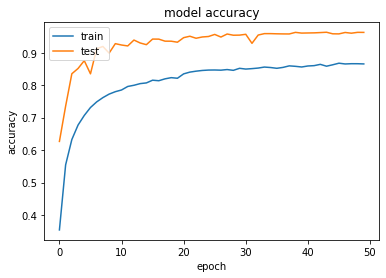

In [19]:
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save model

In [20]:
model_name = "TSR_Model_96perEpoch35_MACM1"

In [21]:
model.save(f'./MODELS/{model_name}')

2022-01-21 18:09:58.941201: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./MODELS/TSR_Model_96perEpoch35_MACM1/assets


In [22]:
model = models.load_model(f'./MODELS/{model_name}')
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

## Prediction

In [23]:
signDict = {}

for i in range(len(Ytrain)):
    
    classs = np.argmax(Ytrain[i])
    
    if classs not in signDict.keys():
        signDict[classs] = i

print(signDict)

{2: 0, 31: 1, 5: 2, 11: 3, 4: 4, 13: 5, 18: 7, 10: 8, 25: 11, 24: 13, 8: 16, 16: 17, 9: 18, 35: 20, 38: 21, 12: 22, 19: 25, 37: 28, 1: 29, 7: 31, 34: 35, 14: 38, 39: 39, 33: 41, 3: 42, 6: 43, 36: 46, 17: 58, 15: 69, 29: 74, 22: 103, 28: 112, 27: 123, 20: 131, 23: 155, 0: 169, 41: 191, 30: 195, 26: 215, 32: 286, 21: 335, 42: 399, 40: 544}


In [24]:
imagePredictionSRC = os.path.join(data_path, "Test/00064.png")

### Load image 

In [25]:
image = cv2.imread(imagePredictionSRC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [26]:
image_rs = cv2.resize(image, (img_size, img_size), 3)        

R, G, B = cv2.split(image_rs)     

img_r = cv2.equalizeHist(R)
img_g = cv2.equalizeHist(G)
img_b = cv2.equalizeHist(B)        

image = cv2.merge((img_r, img_g, img_b))

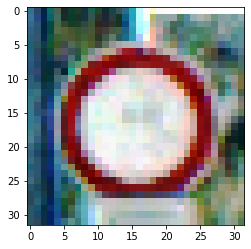

In [27]:
plt.imshow(image)

### Predict image

In [28]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32') / 255. 

In [29]:
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)[0]

2022-01-21 18:09:59.884346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


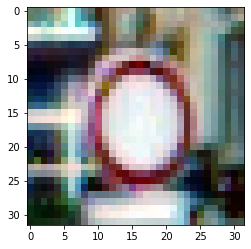

In [30]:
plt.imshow(Xtrain[signDict[predicted_class]])